# Data Augmentation

# 데이터 증강 (Data Augmentation)


## 개요

이 튜토리얼에서는 이미지 회전과 같은 무작위(그러나 사실적인) 변환을 적용하여 훈련 세트의 다양성을 증가시키는 기술인 데이터 증강의 예를 보여줍니다. 두 가지 방법으로 데이터 증강을 적용하는 방법을 배웁니다. 먼저, [Keras 전처리 레이어](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/)를 사용하고, 그 다음으로 `tf.image`를 사용합니다.

## 설정

In [ ]:
!pip install tf-nightly

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import layers

## 데이터세트 다운로드

이 튜토리얼에서는 [tf_flowers](https://www.tensorflow.org/datasets/catalog/tf_flowers) 데이터세트를 사용합니다. 편의를 위해 [TensorFlow Datasets](https://www.tensorflow.org/datasets)를 사용하여 데이터세트를 다운로드합니다. 데이터를 가져오는 다른 방법을 알아보려면 [이미지 로드](https://www.tensorflow.org/tutorials/load_data/images) 튜토리얼을 참조하세요.


In [ ]:
(train_ds, val_ds, test_ds), metadata = tfds.load(
    'tf_flowers',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead pass
`try_gcs=True` to `tfds.load` or set `data_dir=gs://tfds-data/datasets`.





Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.


꽃 데이터세트에는 5개의 클래스가 있습니다.

In [ ]:
num_classes = metadata.features['label'].num_classes
print(num_classes)

5


데이터세트에서 이미지를 검색하고 이를 사용하여 데이터 증강을 수행하겠습니다.

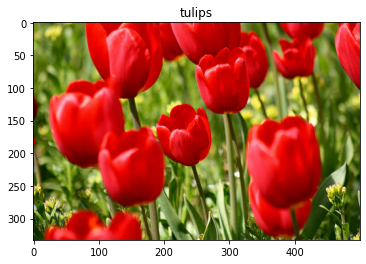

In [ ]:
get_label_name = metadata.features['label'].int2str

image, label = next(iter(train_ds))
_ = plt.imshow(image)
_ = plt.title(get_label_name(label))

## Keras 전처리 레이어 사용하기

참고: 이 섹션에서 소개하는 [Keras 전처리 레이어](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing)는 현재 실험적 단계입니다.

### 크기 및 배율 조정하기


전처리 레이어를 사용하여 이미지를 일관된 모양으로 [크기 조정](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/Resizing)하고 픽셀 값의 [배율을 조정](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/Rescaling)할 수 있습니다.

In [ ]:
IMG_SIZE = 180

resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMG_SIZE, IMG_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255)
])

참고: 위의 배율 조정 레이어는 픽셀 값을 `[0,1]`로 표준화합니다. 그렇지 않고 `[-1,1]`을 원할 경우, `Rescaling(1./127.5, offset=-1)`을 작성하면 됩니다.


이러한 레이어를 이미지에 적용한 결과를 볼 수 있습니다. 

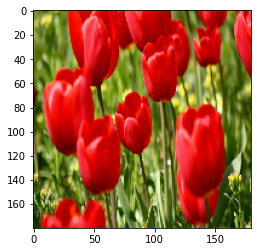

In [ ]:
result = resize_and_rescale(image)
_ = plt.imshow(result)

픽셀이 `[0-1]`에 있는지 확인할 수 있습니다.

In [ ]:
print("Min and max pixel values:", result.numpy().min(), result.numpy().max())

Min and max pixel values: 0.0 1.0


### 데이터 증강

데이터 증강에도 전처리 레이어를 사용할 수 있습니다.

몇 개의 전처리 레이어를 만들어 동일한 이미지에 반복적으로 적용 해 보겠습니다.

In [ ]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

# https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing

In [ ]:
# Add the image to a batch
image = tf.expand_dims(image, 0)

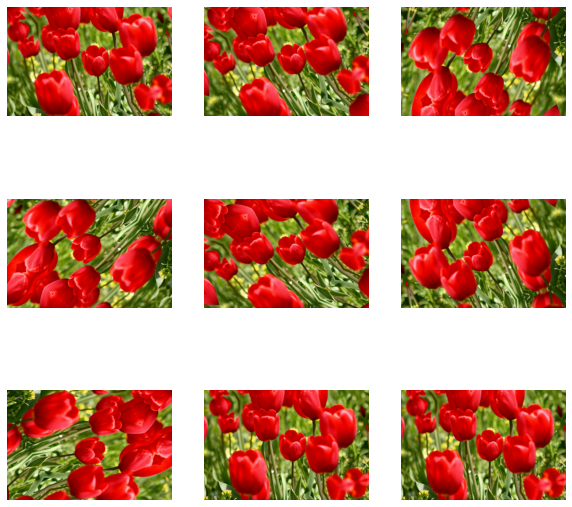

In [ ]:
plt.figure(figsize=(10, 10))
for i in range(9):
  augmented_image = data_augmentation(image)
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(augmented_image[0])
  plt.axis("off")

`layers.RandomContrast`, `layers.RandomCrop`, `layers.RandomZoom` 등 데이터 증강에 사용할 수 있는 다양한 전처리 [레이어](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing)가 있습니다.

### 전처리 레이어를 사용하는 두 가지 옵션

중요한 절충을 통해 이러한 전처리 레이어를 사용할 수 있는 두 가지 방법이 있습니다.

#### 옵션 1: 전처리 레이어를 모델의 일부로 만들기

In [ ]:
model = tf.keras.Sequential([
  resize_and_rescale,
  data_augmentation,
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  # Rest of your model
])

이 경우 유의해야 할 두 가지 중요한 사항이 있습니다.

- 데이터 증강은 나머지 레이어와 동기적으로 기기에서 실행되며 **GPU 가속**을 이용합니다.

- `model.save`를 사용하여 모델을 내보낼 때 전처리 레이어가 모델의 나머지 부분과 함께 저장됩니다. 나중에 이 모델을 배포하면 레이어 구성에 따라 이미지가 자동으로 표준화됩니다. 이를 통해 서버측 논리를 다시 구현해야 하는 노력을 덜 수 있습니다.

참고: 데이터 증강은 테스트할 때 비활성화되므로 입력 이미지는 `model.fit`(`model.evaluate` 또는 `model.predict`가 아님) 호출 중에만 증강됩니다.

#### 옵션 2: 데이터세트에 전처리 레이어 적용하기

In [ ]:
aug_ds = train_ds.map(
  lambda x, y: (resize_and_rescale(x, training=True), y))

이 접근 방식에서는 `Dataset.map`을 사용하여 증강 이미지 배치를 생성하는 데이터세트를 만듭니다. 이 경우에는 다음과 같습니다.

- 데이터 증강은 **CPU**에서 비동기적으로 이루어지며 차단되지 않습니다. 아래와 같이 `Dataset.prefetch`를 사용하여 GPU에서 모델 훈련을 데이터 전처리와 중첩할 수 있습니다.
- 이 경우, 전처리 레이어는 `model.save`를 호출할 때 모델과 함께 내보내지지 않습니다. 저장하기 전에 이 레이어를 모델에 연결하거나 서버측에서 다시 구현해야 합니다. 훈련 후, 내보내기 전에 전처리 레이어를 연결할 수 있습니다.


[이미지 분류](https://www.tensorflow.org/tutorials/images/classification) 튜토리얼에서 첫 번째 옵션의 예를 볼 수 있습니다. 여기에서는 두 번째 옵션을 살펴보겠습니다.

### 데이터세트에 전처리 레이어 적용하기

위에서 생성한 전처리 레이어로 훈련, 검증 및 테스트 데이터세트를 구성합니다. 또한 병렬 읽기 및 버퍼링된 프리페치를 사용하여 I/O 차단 없이 디스크에서 배치를 생성하여 성능을 높이도록 데이터세트를 구성합니다. [tf.data API로 성능 향상하기](https://www.tensorflow.org/guide/data_performance) 가이드에서 데이터세트 성능에 대해 자세히 알아볼 수 있습니다. 

참고: 데이터 증강은 훈련 세트에만 적용해야 합니다.

In [ ]:
batch_size = 32
AUTOTUNE = tf.data.experimental.AUTOTUNE

def prepare(ds, shuffle=False, augment=False):
  # Resize and rescale all datasets
  ds = ds.map(lambda x, y: (resize_and_rescale(x), y), 
              num_parallel_calls=AUTOTUNE)

  if shuffle:
    ds = ds.shuffle(1000)

  # Batch all datasets
  ds = ds.batch(batch_size)

  # Use data augmentation only on the training set
  if augment:
    ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), 
                num_parallel_calls=AUTOTUNE)

  # Use buffered prefecting on all datasets
  return ds.prefetch(buffer_size=AUTOTUNE)

In [ ]:
train_ds = prepare(train_ds, shuffle=True, augment=True)
val_ds = prepare(val_ds)
test_ds = prepare(test_ds)

### 모델 훈련하기

완성도를 높이기 위해 이제 이러한 데이터세트를 사용하여 모델을 훈련합니다. 이 모델은 정확성에 목표를 두고 조정되지 않았습니다(작동 방식을 시연하는 것이 목표임).

In [ ]:
model = tf.keras.Sequential([
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
epochs=5
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/5
92/92 [==============================] - 45s 128ms/step - loss: 1.4877 - accuracy: 0.3378 - val_loss: 1.2423 - val_accuracy: 0.5204
Epoch 2/5
92/92 [==============================] - 10s 101ms/step - loss: 1.1254 - accuracy: 0.5490 - val_loss: 1.0362 - val_accuracy: 0.5995
Epoch 3/5
92/92 [==============================] - 10s 102ms/step - loss: 1.0058 - accuracy: 0.5877 - val_loss: 0.9426 - val_accuracy: 0.6757
Epoch 4/5
92/92 [==============================] - 10s 102ms/step - loss: 0.9304 - accuracy: 0.6285 - val_loss: 0.9565 - val_accuracy: 0.6322
Epoch 5/5
92/92 [==============================] - 10s 102ms/step - loss: 0.8918 - accuracy: 0.6547 - val_loss: 0.8652 - val_accuracy: 0.6785


In [ ]:
loss, acc = model.evaluate(test_ds)
print("Accuracy", acc)

12/12 [==============================] - 1s 42ms/step - loss: 0.9024 - accuracy: 0.6431
Accuracy 0.6430517435073853


### 사용자 정의 데이터 증강

사용자 정의 데이터 증강 레이어를 만들 수도 있습니다. 이 튜토리얼에서는 두 가지 방법을 소개합니다. 먼저, `layers.Lambda` 레이어를 생성합니다. 이것은 간결한 코드를 작성하는 좋은 방법입니다. 다음으로, 제어력을 높여주는 [서브 클래스 생성](https://www.tensorflow.org/guide/keras/custom_layers_and_models)을 통해 새 레이어를 작성합니다. 두 레이어는 확률에 따라 이미지의 색상을 무작위로 반전합니다. 

In [ ]:
def random_invert_img(x, p=0.5):
  if  tf.random.uniform([]) < p:
    x = (255-x)
  else:
    x
  return x

In [ ]:
def random_invert(factor=0.5):
  return layers.Lambda(lambda x: random_invert_img(x, factor))

random_invert = random_invert()

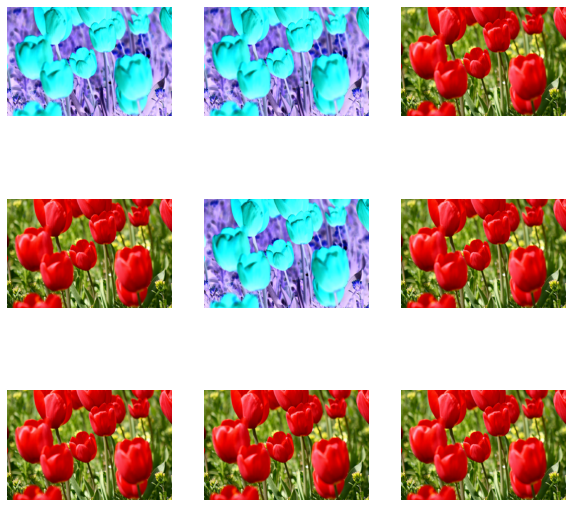

In [ ]:
plt.figure(figsize=(10, 10))
for i in range(9):
  augmented_image = random_invert(image)
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(augmented_image[0].numpy().astype("uint8"))
  plt.axis("off")

다음으로, [서브 클래스 생성](https://www.tensorflow.org/guide/keras/custom_layers_and_models)을 통해 사용자 정의 레이어를 구현합니다.

In [ ]:
class RandomInvert(layers.Layer):
  def __init__(self, factor=0.5, **kwargs):
    super().__init__(**kwargs)
    self.factor = factor

  def call(self, x):
    return random_invert_img(x)

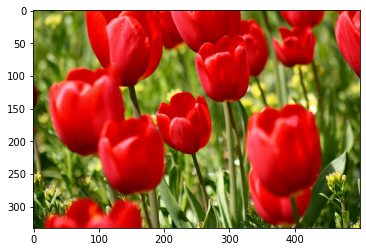

In [ ]:
_ = plt.imshow(RandomInvert()(image)[0])

위의 옵션 1과 2의 설명에 따라 이 두 레이어를 모두 사용할 수 있습니다.

## tf.image 사용하기

위의 `layers.preprocessing` 유틸리티는 편리합니다. 보다 세밀한 제어를 위해서는 `tf.data` 및 `tf.image`를 사용하여 고유한 데이터 증강 파이프라인 또는 레이어를 작성할 수 있습니다. [TensorFlow 애드온 이미지: 작업](https://www.tensorflow.org/addons/tutorials/image_ops) 및 [TensorFlow I/O: 색 공간 변환](https://www.tensorflow.org/io/tutorials/colorspace)도 확인해보세요.

꽃 데이터세트는 이전에 데이터 증강으로 구성되었으므로 다시 가져와서 새로 시작하겠습니다.

In [ ]:
(train_ds, val_ds, test_ds), metadata = tfds.load(
    'tf_flowers',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)

작업할 이미지를 검색합니다.

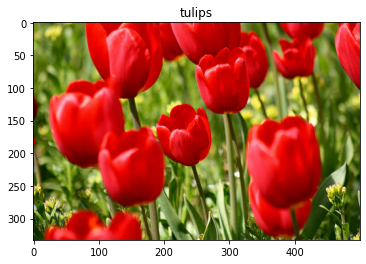

In [ ]:
image, label = next(iter(train_ds))
_ = plt.imshow(image)
_ = plt.title(get_label_name(label))

다음 함수를 사용하여 원본 이미지와 증강 이미지를 나란히 시각화하고 비교하겠습니다.

In [ ]:
def visualize(original, augmented):
  fig = plt.figure()
  plt.subplot(1,2,1)
  plt.title('Original image')
  plt.imshow(original)

  plt.subplot(1,2,2)
  plt.title('Augmented image')
  plt.imshow(augmented)

### 데이터 증강

### 이미지 뒤집기

이미지를 수직 또는 수평으로 뒤집습니다.

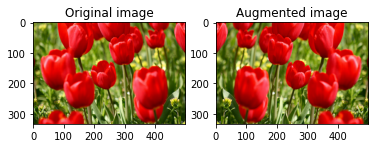

In [ ]:
flipped = tf.image.flip_left_right(image)
visualize(image, flipped)

### 이미지를 회색조로 만들기

이미지를 회색조로 만듭니다.

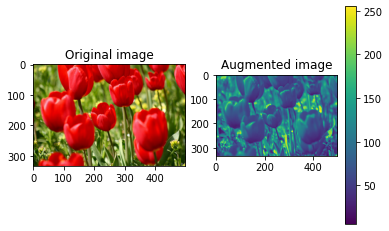

In [ ]:
grayscaled = tf.image.rgb_to_grayscale(image)
visualize(image, tf.squeeze(grayscaled))
_ = plt.colorbar()

### 이미지 포화시키기

채도 계수를 제공하여 이미지를 포화시킵니다.

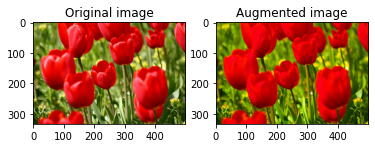

In [ ]:
saturated = tf.image.adjust_saturation(image, 3)
visualize(image, saturated)

### 이미지 밝기 변경하기

밝기 계수를 제공하여 이미지의 밝기를 변경합니다.

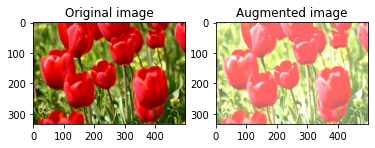

In [ ]:
bright = tf.image.adjust_brightness(image, 0.4)
visualize(image, bright)

### 이미지 중앙 자르기

이미지를 중앙에서 원하는 이미지 부분까지 자릅니다.

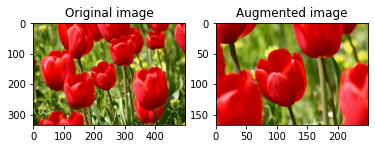

In [ ]:
cropped = tf.image.central_crop(image, central_fraction=0.5)
visualize(image,cropped)

### 이미지 회전하기

이미지를 90도 회전합니다.

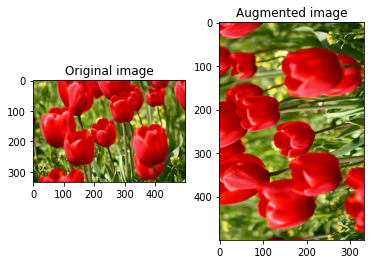

In [ ]:
rotated = tf.image.rot90(image)
visualize(image, rotated)

### 데이터세트에 증강 적용하기

이전과 마찬가지로 `Dataset.map`을 사용하여 데이터 증강을 데이터세트에 적용합니다.

In [ ]:
def resize_and_rescale(image, label):
  image = tf.cast(image, tf.float32)
  image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
  image = (image / 255.0)
  return image, label

In [ ]:
def augment(image,label):
  image, label = resize_and_rescale(image, label)
  # Add 6 pixels of padding
  image = tf.image.resize_with_crop_or_pad(image, IMG_SIZE + 6, IMG_SIZE + 6) 
   # Random crop back to the original size
  image = tf.image.random_crop(image, size=[IMG_SIZE, IMG_SIZE, 3])
  image = tf.image.random_brightness(image, max_delta=0.5) # Random brightness
  image = tf.clip_by_value(image, 0, 1)
  return image, label

### 데이터세트 구성하기

In [ ]:
train_ds = (
    train_ds
    .shuffle(1000)
    .map(augment, num_parallel_calls=AUTOTUNE)
    .batch(batch_size)
    .prefetch(AUTOTUNE)
) 

In [ ]:
val_ds = (
    val_ds
    .map(resize_and_rescale, num_parallel_calls=AUTOTUNE)
    .batch(batch_size)
    .prefetch(AUTOTUNE)
)

In [ ]:
test_ds = (
    test_ds
    .map(resize_and_rescale, num_parallel_calls=AUTOTUNE)
    .batch(batch_size)
    .prefetch(AUTOTUNE)
)

이제 이러한 데이터세트를 사용하여 이전에 표시한 대로 모델을 훈련할 수 있습니다.